#### ※ There are many many works that require CPU resource, so i7 would be good if intel cpu is used. 8 to 16 GB of ram is recommended. This project uses machine learning instead of deep learning, so GPU with high spec is not needed.  

### 1. Analyse and visualise some relevant dataset(s) – produce charts and document observations
(5 marks)

##### This chatbot is travel related information chatbot. Since it needs to answer travel related questions, two datasets were used. ATIS and Out-of-Scope Prediction Data (url: https://github.com/clinc/oos-eval) was used. Not all of the labels in the datasets were used for this project. Labels that are needed for this projects were used, which are atis_airline, atis_flight, atis_flight_time, current_location, distance, timezone, travel_suggestion, and weather. Information on these nine labels were extracted from the two datasets to be used for this chatbot project intent classification. 

* Ignore warnings setting

In [ ]:
import warnings
warnings.filterwarnings('ignore')

* Filter intent data that are needed 

In [ ]:
import pandas as pd

#load Out-of-Scope Prediction data
f= pd.read_csv("./dataset/data.csv", encoding='cp949')

#extract necessary columns
f=f[['sentence','intent']]

#list intents that are needed
atis_intents = ['current_location','distance', 'timezone','travel_suggestion', 'weather']

#filtering function to get list of intents needed
def filtering(x):
    # if a row belongs to the list of intent needed make that row True, if not make it false.
    if x in atis_intents:
        return True
    else:
        return False

# use filtering function to filter columns that I need, and get the coressponding index of them.
idx = f['intent'].apply(filtering)

# get the rows that are True, and save them in filtered_data.
filtered_data = f[idx]

# save filtered data in csv file format.W
filtered_data.to_csv("./filtered_data.csv", index=False, encoding='cp949')

* Data split

In [ ]:
# import modules that I need.
# import sklearn and other moudules that I need like sklearn.
from sklearn import *
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
# module to save models
import joblib
# use pandas to preprocess and load data.
import pandas as pd
# library that turn texts to vector
import spacy
# library that is needed for matrix operations.
import numpy as np

# load ATIS dataset and set columns. 
X = pd.read_csv("./dataset/atis_intents_train.csv", header=None)
X.columns= ['label', 'query']
X_test = pd.read_csv("./dataset/atis_intents_test.csv", header=None)
X_test.columns = ['label', 'query']

# load Git hub dataset (Data reference URL: https://github.com/clinc/oos-eval) 
X2 = pd.read_csv("filtered_data.csv")
# set column names for filtered data.
X2.columns= ['query', 'label']

#list intents that are needed
intents = ['atis_airfare','atis_airline','atis_flight','atis_flight_time']

#filtering function to get list of intents needed
def filtering(x):
    # if a row belongs to the list of intent needed make that row True, if not make it false.
    if x in intents:
        return True
    else:
        return False

# use filtering function to filter columns that I need, and get the coressponding index of them.
X_idx = X['label'].apply(filtering)
X_test_idx = X_test['label'].apply(filtering)

# concatenate data
X = pd.concat([X[X_idx],X_test[X_test_idx],X2])

* Data print

In [ ]:
print(X)

                 label                                              query
0          atis_flight   i want to fly from boston at 838 am and arriv...
1          atis_flight   what flights are available from pittsburgh to...
2     atis_flight_time   what is the arrival time in san francisco for...
3         atis_airfare            cheapest airfare from tacoma to orlando
4         atis_airfare   round trip fares from pittsburgh to philadelp...
...                ...                                                ...
3542           weather                       you want to know the weather
3543           weather                      tell me the weather for today
3544           weather               please tell me the weather for today
3545           weather                   what is the current weather like
3546           weather                     the weather today in las vegas

[8566 rows x 2 columns]


* Data class histogram

(array([4298.,   55.,  471.,  195.,    0.,  857.,  572.,  840.,  653.,
         625.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

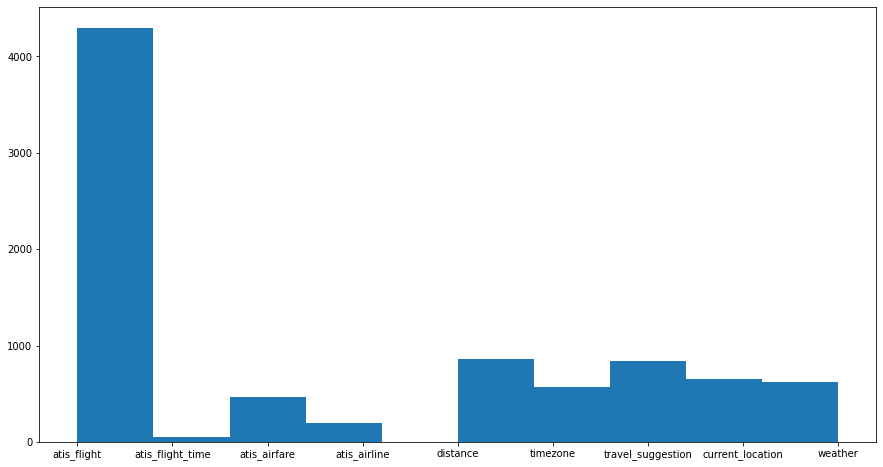

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.hist(X['label'])

* Class imbalance preprocessing

In [ ]:
# To reduce class imbalance of atis_flight, reduce the number of atis_flight to reasonable number.
condition = (X.label == 'atis_flight')

Non_condition = (X.label != 'atis_flight')

X = pd.concat([X[condition].iloc[0:500,:],X[Non_condition]])

# shuffwle X data row, and reset index
f_X = X.sample(frac=1).reset_index(drop=True) 

# Data split 
X = f_X[:int(len(f_X)*0.8)]
X_test = f_X[int(len(f_X)*0.8):]
X

,label,query
0,weather,is it hot outside?
1,current_location,how do i find my current place?
2,travel_suggestion,list some attractions in gatlinburg?
3,current_location,show my position on the map
4,weather,will it be hot tomorrow?
...,...,...
3809,current_location,how do i know where i'm at?
3810,atis_flight,which united airlines flight flies across thi...
3811,atis_airline,which airlines fly into and out of denver
3812,current_location,where are we located


(array([498., 510., 674., 400.,   0., 470.,  49., 682., 151., 380.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

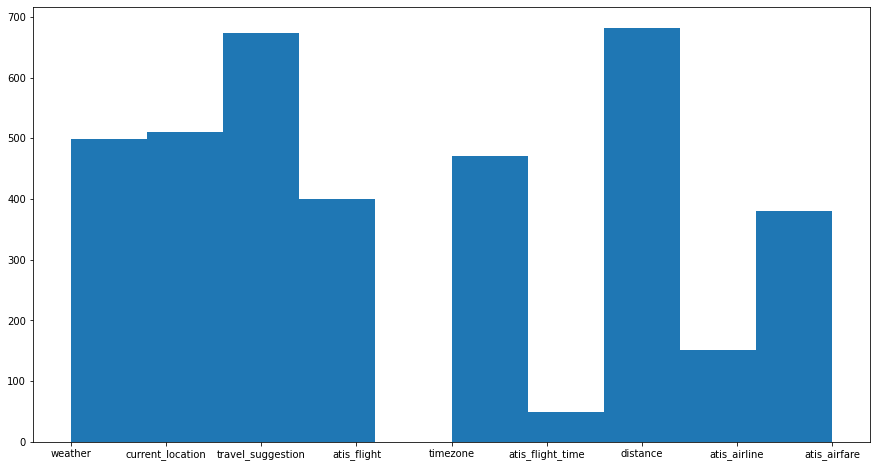

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.hist(X['label'])

* Spacy en_core_web_md install for Data vectorization

In [ ]:
!python -m spacy download en_core_web_md

* Spacy data vectorization 

In [ ]:
# en_core_web_md load
nlp = spacy.load("en_core_web_md")

# label data filtering
X_df = X[X["label"].str.contains("#")==False]
x_test_df = X_test[X_test["label"].str.contains("#")==False]

# change train data to list type
x_train_query = X_df['query'].tolist()
x_train_label = X_df['label'].tolist()

# change test data to list type
x_test_query = x_test_df['query'].tolist()
x_test_label = x_test_df['label'].tolist()

# use map and lambda function to vectorize query data of each train and test data.
train_X = list(map(lambda x: list(nlp(x).vector), x_train_query))
test_X = list(map(lambda x: list(nlp(x).vector), x_test_query))

# change label data from String label to Scalar label using LabelEncoder

le = LabelEncoder()
train_label = le.fit_transform(x_train_label)
test_label = le.fit_transform(x_test_label)

# train_label and test_label info
# atis_airfare: 0
# atis_airline: 1
# atis_flight: 2
# atis_flight_time: 3
# current_location: 4
# distance: 5
# timezone: 6
# travel_suggestion: 7
# weather: 8

#### 2. Work on the following components of your chatbot.
#### a. Intent classification, where a multi-class type model should predict the user intent

##### Experimentation with (at least two) different variations, where you might be trying out different options such as (listing more than two different experiments here, so choose two):

##### II. NLP algorithms/techniques – explain your choice (e.g., I am comparing SVM, FNN, etc. to understand their advantages and disadvantages when trained with the dataset…)
##### Answer: XGBoost is a ensemble model. XGBoost uses models that are in XGBoost, and XGBoost performs freqeuncy based classification, so XGBoost gives favorable accuracy results. XGBoost almost always gives higher accuracy compared to using Randomforest model, and XGBoost has advantages of boosting ensemble models. There are lines of code below that compared both model's performance for the dataset is used for this project.

##### VI. hyperparameter optimisation – what are the most appropriate values (e.g. learning rate, training cycles, etc., depending on the algorithm)

##### Answer: To find the most optimal hyper-parameter for the model, bayesian optimization was used. Unlike grid search or random search, bayesian optimization performs experiments N times, which allows more detailed and optimal prediction of hyper-parameter using the results from the experiments that were performed. 

* XGBoostClassifier define & hyper-parameter turning

In [ ]:
# import metric from sklearn to test model's performance
from sklearn.metrics import *
# import XGBoost, which will be used for classification.
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier


# use XGBoostClassifier and Bayesian optimizer to set search function that can do hyper-parameter turning.
def XGB_cv(max_depth,learning_rate, n_estimators):

    # initialize XGboostClassifier
    clf = xgb.XGBClassifier(max_depth=int(max_depth),
                            learning_rate=learning_rate,
                            n_estimators=int(n_estimators)
                            ,verbosity = 0, nthread = -1)

    # model fitting
    clf.fit(train_X, train_label)

    # model inference by test data
    y_pred= clf.predict(test_X)

    # test model's inference accuracy using model inference data and answers.
    auc = f1_score(test_label, y_pred, average='micro')

    # use bayesian optimization to return metric that will be used for hyper-parameter optimization.
    return auc

* Training XGBClassifier

In [ ]:
# import Bayesian Optimization class from byesian-optimization library
from bayes_opt import BayesianOptimization

# set of hyperparameters to test
# max_depth(int, default: 3): list of maximum tree depth
# learning_rate(float, default: 0.1) : list of learning rate settings
# n_estimators ( int, default : 100) : number of Boosted tree to fit

pbounds = {'max_depth': (1, 100),
            'learning_rate': (0.001, 0.1),
            'n_estimators': (10,10000)
            }

# generate Bayesian optimization object
# f : target explorer function, pbounds: set of hyperparameter
# verbose = 2 always print, verbose = 1 print when it is max, verbose = 0 : don't print
bo=BayesianOptimization(f=XGB_cv, pbounds=pbounds, verbose=2, random_state=1 )    

# maximization using method
# init_points : initial number of random search
# n_iter : number of repeats (more accurate results can be obtained as more input value and function values are checked)
# acq : use Expected Improvement(EI) from Acquistion Function
# xi : strength of exploration (default value 0.0) 
bo.maximize(init_points=4, n_iter=20, acq='ei', xi=0.01)

# check the value of hyper-parameter found
print(bo.max)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
|  1        |  0.8753   |  0.04229  |  72.31    |  11.14    |
|  2        |  0.9287   |  0.03093  |  15.53    |  932.5    |
|  3        |  0.9329   |  0.01944  |  35.21    |  3.974e+0 |
|  4        |  0.9403   |  0.05434  |  42.5     |  6.855e+0 |
|  5        |  0.9287   |  0.002257 |  36.56    |  6.853e+0 |
|  6        |  0.9382   |  0.01877  |  54.08    |  6.868e+0 |
|  7        |  0.9392   |  0.07242  |  56.34    |  6.85e+03 |
|  8        |  0.9434   |  0.04275  |  6.146    |  3.954e+0 |
|  9        |  0.9403   |  0.03356  |  14.33    |  3.934e+0 |
|  10       |  0.9392   |  0.04755  |  42.93    |  4.724e+0 |
|  11       |  0.9497   |  0.04123  |  3.806    |  3.981e+0 |
|  12       |  0.934    |  0.04938  |  84.28    |  9.791e+0 |
|  13       |  0.9371   |  0.03292  |  76.59    |  8.571e+0 |
|  14       |  0.9361   |  0.04358  |  77.33    |  8.572e+0 |
|  15   

* Model training by Best hyper-parameter 

In [ ]:
# using the most optimal hyper-parameter found train the model, and measure the accuracy of the model.
clf = xgb.XGBClassifier(max_depth=4,
                            learning_rate=0.04123,
                            n_estimators=3981,
                            verbosity = 0)
clf.fit(train_X, train_label)
y_pred= clf.predict(test_X)
auc = f1_score(test_label, y_pred,average='micro')
print(auc)

0.9633123689727463


* Model save

In [ ]:
# save the fitted model as pickle file.
joblib.dump(clf, './trained.pkl')

['./trained.pkl']

#### 3. Perform testing for each of the experiments conducted above – show visuals, such as confusion matrix or other relevant metrics for each experiment (10 marks)


* Model load and test score

In [ ]:
# load the model to test whether if model performs inference correctly or not.
saved_model = joblib.load('./trained.pkl') 
saved_model.predict(test_X)
auc = accuracy_score(test_label, y_pred)
print(auc)

0.9454926624737946


* Confusion matrix

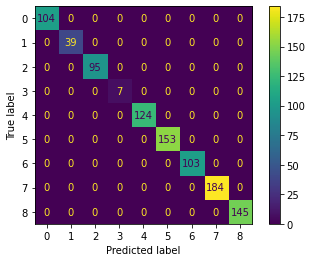

In [ ]:
plot_confusion_matrix(saved_model,test_X, y_pred)
plt.show()

* Test Question and chatbot answer

In [ ]:
saved_model.predict(list([nlp('where is my location').vector]))

array([4])

* Training RandomForestClassifier

In [ ]:
# use RandomForestClassifier and Bayesian optimizer to set search function that can do hyper-parameter turning.
def rf_cv(max_depth, n_estimators):

    # initialize RandomForestClassifier
    rf = RandomForestClassifier(max_depth=int(max_depth),
                            n_estimators=int(n_estimators),verbose=0,n_jobs=-1)

    # model fitting
    rf.fit(train_X, train_label)

    # model inference by test data
    y_pred= rf.predict(test_X)

    # test model's inference accuracy using model inference data and answers.
    auc = f1_score(test_label, y_pred, average='micro')

    # use bayesian optimization to return metric that will be used for hyper-parameter optimization.
    return auc

In [ ]:
# set of hyperparameters to test
pbounds = {'max_depth': (1, 100),
            'n_estimators': (10,10000)
            }

# generate Bayesian optimization object
bo2=BayesianOptimization(f=rf_cv, pbounds=pbounds, verbose=2, random_state=1 )    

# maximization using method
bo2.maximize(init_points=4, n_iter=20, acq='ei', xi=0.01)

# check the value of hyper-parameter found
print(bo2.max)

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
|  1        |  0.9361   |  42.29    |  7.206e+0 |
|  2        |  0.4403   |  1.011    |  3.03e+03 |
|  3        |  0.9319   |  15.53    |  932.5    |
|  4        |  0.935    |  19.44    |  3.462e+0 |
|  5        |  0.9361   |  39.98    |  7.203e+0 |
|  6        |  0.9361   |  15.19    |  3.687e+0 |
|  7        |  0.9329   |  72.92    |  575.9    |
|  8        |  0.935    |  98.1     |  6.743e+0 |
|  9        |  0.9099   |  8.724    |  6.335e+0 |
|  10       |  0.4413   |  1.515    |  148.6    |
|  11       |  0.935    |  98.18    |  752.8    |
|  12       |  0.7987   |  4.542    |  1.36e+03 |
|  13       |  0.848    |  5.752    |  7.628e+0 |
|  14       |  0.935    |  93.42    |  5.894e+0 |
|  15       |  0.608    |  2.806    |  5.563e+0 |
|  16       |  0.934    |  100.0    |  6.075e+0 |
|  17       |  0.935    |  100.0    |  6.976e+0 |
|  18       |  0.934    |  100.0    |  3.569e+0 |


#### b. Name Entity Recognition (NER), where a model should be fine-tuned to extract needed entities from the user’s input (e.g., dates, places, etc.)

Import required libs

In [ ]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

Test sentence

In [ ]:
sentence = "How long is it from Korea to the US?"

Creating a list of tuples generated from model

In [ ]:
doc = nlp(sentence)
hello =([(X.text, X.label_) for X in doc.ents])

Function to parse list of tuples generated by model

In [ ]:
def entity_name(name):
    for entity in hello:
        if entity[1] == name:
            print(entity[0])

Results

In [ ]:
print("Location:")
entity_name("GPE")

Location:
Korea
US


#### c.    Dialogue Flow manager, where a mechanism should try and predict what the chatbot’s next action should be (can be simple heuristics and/or ML model)

In [ ]:
import chatbot_ui.intent
import chatbot_ui.intent_NER_to_answer
import chatbot_ui.NER


sentence = "How long is it from Korea to the US?"
#prediction intent, NER
intent_predict= chatbot_ui.intent.intent_classification(sentence)

NER_predict= chatbot_ui.NER.NER_predict(sentence)
print(intent_predict,NER_predict)

# make answer by intent and NER 
response = chatbot_ui.intent_NER_to_answer.make_answer(intent_predict,NER_predict)

print("User: ",sentence)
print("Chatbot: ",response)

4. Discuss results from the test on all the experiments you conducted and mention if there was any need to adjust any variables and re-run the experiment (10 marks)

Answer: In intent classification XGBoost model resulted in accuracy of about 95%. Random forest model resulted in 93% accuracy. Each model's hyper-parameters were found using bayesian optimizer, so I did not need change the hyper-parameters of the models. I could have added more variables or do additional pre-processing during pre-processing or compare many other models available to get better accuracy, but the test shows satisfactory results. During actual use of the model, if the chatbot gives inaccurate answer, the user can always ask the question again.  

5. Evaluate the overall attempt and outcome – this goes beyond the accuracy of the models, so some important questions to consider here are:

a. “Can the chatbot components you experimented with fulfil their purpose?”

Answer: Model for intent classification has about accuracy fo 95%, so it would be able to fulfil the purpose for the intent classificaiton of the coursework chatbot.

b. “What is good enough accuracy?”

Answer: Good enough accuracy is when a user uses the chatbot the user does not feel a lot of inconvenience. If a wrong answer is given by the chatbot, I can try to lead the user to ask the question again. 

c. If any of the models did not perform well, what is needed to 
improve?

Answer: If the model's performance is not high enough. I can reduce the number of intents to reduce the complexity which could increase the accuracy, increase the number of data, or change the pre-processing method. Datasets have different models that gives best accuracy for that certain dataset, so there is also need to test many different models for the dataset. 

d. If any of the models performed really well, could you make it more efficient and sacrifice some quality?

Answer: It is always worth it to use better models that give better accuracy, but chatbots need high accuracy and high answer speed. I would evaluate the model with higher accuracy to check if it uses high computing resource then choose to use the model or not use the model.

#### Reference: 

1. GitHub. (n.d.). GitHub - clinc/oos-eval: Repository that accompanies ‘An Evaluation Dataset for Intent Classification and Out-of-Scope Prediction’ (EMNLP 2019). [online] Available at: https://github.com/clinc/oos-eval.

2. www.kaggle.com. (n.d.). ATIS Airline Travel Information System. [online] Available at: https://www.kaggle.com/datasets/hassanamin/atis-airlinetravelinformationsystem.

3. Bayesian-optimization: https://github.com/fmfn/BayesianOptimization
4. xgboost: https://xgboost.readthedocs.io/en/stable/